In [1]:
from importlib.metadata import version
print("torch version:", version("torch"))

torch version: 2.8.0+cu126


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [3]:
## Import code from previous chapters
import torch.nn as nn

class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) *
        (x + 0.44715 * torch.pow(x, 3))
    ))

class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
        GELU(),
        nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
    )

  def forward(self, x):
    return self.layers(x)

class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out,
               context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    assert (d_out % num_heads == 0), \
        "d_out must be divisible by num_heads"

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
        "mask",
        torch.triu(torch.ones(context_length, context_length),
                   diagonal=1)
    )

  def forward(self, x):
    b, num_tokens, d_in = x.shape
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(
        b, num_tokens, self.num_heads, self.head_dim
    )

    keys = keys.transpose(1, 2)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2)

    attn_scores = queries @ keys.transpose(2, 3)
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

    attn_scores.masked_fill_(mask_bool, -torch.inf)

    attn_weights = torch.softmax(
        attn_scores / keys.shape[-1]**0.5, dim = -1
    )
    attn_weights = self.dropout(attn_weights)

    context_vec = (attn_weights @ values).transpose(1, 2)

    context_vec = context_vec.contiguous().view(
        b, num_tokens, self.d_out
    )
    context_vec = self.out_proj(context_vec)
    return context_vec

#   The transformer block component of GPT
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_length"],
        num_heads = cfg["n_heads"],
        dropout = cfg["drop_rate"],
        qkv_bias = cfg["qkv_bias"])

    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut
    return x

class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias = False
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)

    pos_embeds = self.pos_emb(
      torch.arange(seq_len, device=in_idx.device)
    )

    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

# Pretraining on unlabeled data

## 5.1 - Evaluating generative text models

### 5.1.1 - Using GPT to generate text

  - Let's set up the LLM.

In [4]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256,  # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [5]:
#   Utility functions for text to token ID conversion
import tiktoken

def generate_text_simple(model, idx,
        max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)

    logits = logits[:, -1, :]
    probas = torch.softmax(logits, dim=-1)
    idx_next = torch.argmax(probas, dim=-1, keepdim=True)
    idx = torch.cat((idx, idx_next), dim=1)

  return idx

def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("Output text: \n", token_ids_to_text(token_ids, tokenizer))

Output text: 
 Every effort moves you rentingetic wasnم refres RexAngel infieldcigans


  - The model isn't yet producing coherent text.
  - Next, we will calculate a loss metric for the generated outputs.

### 5.1.2 - calculating the text generation loss

  - Techniques for numerically assessing text quality generated during training by calculating a text generation loss.

In [6]:
#   Consider two input examples, which have already been mapped
inputs = torch.tensor([[16833, 3626, 6100],  # ["every effort moves",
                       [40,    1107, 588]])  # "I really like"]

targets = torch.tensor([[3626, 6100, 345],     # [" effort moves you",
                        [1107, 588,  11311]])  # "really like chocolate"]

#   Now feed the inputs into model to calculate logits vectors for thewo input
# examples, each of three tokens.
with torch.no_grad():
  logits = model(inputs)
probas = torch.softmax(logits, dim = -1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [7]:
#   The first number, 2, corresponds to the two examples (rows)
#
#   The second number, 3, corresponds to the number of tokens in each input (row)
#
#   The last number corresponds to the embedding dimensionality, which is determined
# by the vocabulary size.

#   Following the conversion from logits to probabilities via the softmax function,
# the generate_text_simple function then converts the resulting probability scores
# back into text
token_ids = torch.argmax(probas, dim = -1, keepdim = True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [8]:
#   Finally convert the token IDs back into text:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 2: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 2:  Armed heNetflix


  - Now we need to evaluate the performance of the model's generated text numerically via a loss.  
  - This is useful for measuring the quality of the generated text, but also as a building block for implementing training function.
  - Part of text evaluation process that we implement, is to measure "how far" the generated tokens are from correct predictions (targets).

In [9]:
#   For each of the two input texts, we can print the initial softmax
# probability scores corresponding to the target torkens using the following code:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.2671e-05, 3.1046e-05, 1.1696e-05])
Text 2: tensor([1.0426e-05, 5.4604e-05, 4.7716e-06])


  - The goal of training an LLM is to maximize the likelihood of the correct token, which involves increasing its probability relative to other tokens.

In [10]:
#   Next, we calculate the loss for the probability scores of the two example batches.
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5296, -10.3800, -11.3563, -11.4712,  -9.8154, -12.2528])


In [11]:
#   Next we combine these log probabilities into a single score
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.8009)


In [12]:
#   The goal is to get the average log probability as close to 0 as possible by
# updating the model's weights as part of the training process.
#
#   The goal is to bring the negative average log probability down to 0.
#
#   The term for turning the negative falu is known as cross entropy loss.
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.8009)


In [13]:
#   Review the shape of the logits and target tensors:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [14]:
#   For the cross_entropy loss function in PyTorch, we want to flatten these
# tensors by combining them over the batch dimension:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits: ", logits_flat.shape)
print("Flattened targets: ", targets_flat.shape)

Flattened logits:  torch.Size([6, 50257])
Flattened targets:  torch.Size([6])


In [15]:
#   Previously, we applied the softmax function, selected the probaility scores
# corresponding to the target IDs, and computed the negative average log
# probabilities.  PyTorch's cross_entropy function will take care of all the
# steps for us:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.8009)


### 5.1.3 - Calculating the training and validation set losses

  - We must first prepare the training and validation datasets that we will use to train the LLM.
  - To compute the loss on the training and validation datasets, we use a very small text dataset.


In [16]:
#   The following code loads "The Verdict"
import urllib.request
url = ("https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/refs/heads/main/ch02/01_main-chapter-code/the-verdict.txt")
file_path = "the-verdict.txt"
urllib.request.urlretrieve(url, file_path)

with open(file_path, "r", encoding="utf-8") as f:
  text_data = f.read()

In [17]:
#   Check the number of charaters and tokens in data set
total_caracters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_caracters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [18]:
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
    self.input_ids = []
    self.target_ids = []

    token_ids = tokenizer.encode(txt)
    for i in range(0, len(token_ids) - max_length, stride):
      input_chunk = token_ids[i:i + max_length]
      target_chunk = token_ids[i + 1: i + max_length + 1]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
  tokenizer = tiktoken.get_encoding("gpt2")
  dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
  dataloader = DataLoader(
      dataset,
      batch_size=batch_size,
      shuffle=shuffle,
      drop_last=drop_last,
      num_workers=num_workers
  )

  return dataloader

In [19]:
#   Next divide the dataset into a training and validation set and use the data
# loaders from chapter 2
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

#   Usie the train_data and val_data subsets, create respective data loaders
torch.manual_seed(123)

train_loader = create_dataloader_v1(
  train_data,
  batch_size=2,
  max_length=GPT_CONFIG_124M["context_length"],
  stride=GPT_CONFIG_124M["context_length"],
  shuffle=True,
  drop_last=True,
  num_workers=0
)
val_loader = create_dataloader_v1(
  val_data,
  batch_size=2,
  max_length=GPT_CONFIG_124M["context_length"],
  stride=GPT_CONFIG_124M["context_length"],
  shuffle=True,
  drop_last=True,
  num_workers=0
)

In [20]:
#   We used a relatively small batch size to reduce the computational resource
# demand because we were working with a very small dataset.
#  Iterate through the data loaders to ensure that they were create correctly:

print("Train loader:")
for x, y in train_loader:
  print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
  print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [21]:
#   Implement a utility function to calculate the cross entropy loss of a given
# batch returned via the training and validation loader:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(
      logits.flatten(0, 1), target_batch.flatten()
  )
  return loss

In [22]:
#   Function to compute the training and validation loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(
          input_batch, target_batch, model, device
      )
      total_loss += loss.item()
    else:
      break

  return total_loss / num_batches

In [23]:
#   Let's see calc_loss_loader function in action
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device)
  val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss: ", train_loss)
print("Validation loss: ", val_loss)

Training loss:  10.987016677856445
Validation loss:  10.980591773986816


  - The loss values are relatively high because the model hasn't been trained.
  
## 5.2 - Training an LLM

  - Time to implement the code for pretraining the LLM.

In [24]:
#   Themain function for pretraining LLMs
def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
  train_losses, val_losses, track_tokens_seen = [], [], []
  tokens_seen, global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()
    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      loss = calc_loss_batch(
          input_batch, target_batch, model, device
      )
      loss.backward()
      optimizer.step()
      tokens_seen += input_batch.numel()
      global_step += 1

      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(
          model, train_loader, val_loader, device, eval_iter
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"Ep {epoch+1} (Step {global_step:06d})"
              f"Train loss {train_loss:.3f}, "
              f"Val loss {val_loss:.3f}"
        )

    generate_and_print_sample(
      model, tokenizer, device, start_context
    )
  return train_losses, val_losses, track_tokens_seen

#   The evaluate_model function calculates the loss over the training and
# validation set wwhile ensuring the model is in evaluation mode with gradient
# tracking and dropout disabled when calculating the loss over the training
# and validation sets:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = calc_loss_loader(
      train_loader, model, device, num_batches=eval_iter
    )
    val_loss = calc_loss_loader(
      val_loader, model, device, num_batches=eval_iter
    )
  model.train()
  return train_loss, val_loss

#   Function used to track whether the model impproves during training.
def generate_and_print_sample(model, tokenizer, device, start_context):
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_simple(
      model=model, idx=encoded,
      max_new_tokens=50, context_size=context_size
    )
  decoded_text = token_ids_to_text(token_ids, tokenizer)
  print(decoded_text.replace("\n", " "))
  model.train()

In [25]:
#   Let's see this all in action by training a GPTModel instance for 10 epochs
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
  model.parameters(),
  lr = 0.0004, weight_decay = 0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000)Train loss 9.764, Val loss 9.903
Ep 1 (Step 000005)Train loss 8.077, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010)Train loss 6.760, Val loss 7.044
Ep 2 (Step 000015)Train loss 6.115, Val loss 6.608
Every effort moves you, the,,,,,,,,,,.                                     
Ep 3 (Step 000020)Train loss 5.769, Val loss 6.525
Ep 3 (Step 000025)Train loss 5.398, Val loss 6.403
Every effort moves you.                                                 
Ep 4 (Step 000030)Train loss 4.753, Val loss 6.312
Ep 4 (Step 000035)Train loss 4.126, Val loss 6.228
Every effort moves you, and, and in the picture of the picture, and I had been, and, in the, and, and, and, and of the, and I had been, as of the picture, in the picture--and, and, in
Ep 5 (Step 000040)Train loss 4.001, Val loss 6.200
Every effort moves you know it was not that, and in the--I had been.                                    
Ep 6 (Step 000045)Train loss 3

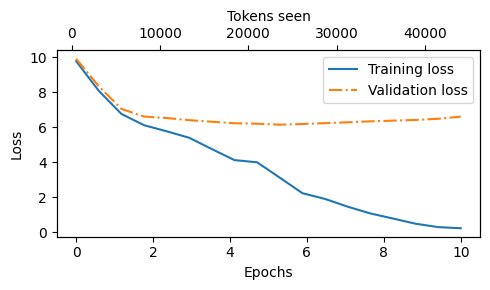

In [36]:
# Simple plot that shows the training and validation set losses side by side:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
  fig, ax1 = plt.subplots(figsize=(5, 3))
  ax1.plot(epochs_seen, train_losses, label="Training loss")
  ax1.plot(
      epochs_seen, val_losses, linestyle="-.", label="Validation loss"
  )
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2 = ax1.twiny()
  ax2.plot(tokens_seen, train_losses, alpha=0)
  ax2.set_xlabel("Tokens seen")
  fig.tight_layout()
  plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- Both the training and validation losses start to improve for the first epoch.  The losses start to diverge past the second epoch.  This divergence and the fact that the validation loss is much larger than the training loss indicate that the model is overfitting to the training data.
- We can confirm that the model memorizes the training data verbatim by searching for the generated text snippets
- The memorization is expected since we are working with a very, small training dataset and training the mode for multiple epochs.

## 5.3 - Decoding strategies to control randomness

- Let's look at text generation strategies.
- We will begin by transferring the model back from GPU to CPU since inference with a relatively small model does not require a GPU.

In [37]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [38]:
#   We plug the GPTModel instance (model) into the generate_text_simple function
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
  model=model,
  idx=text_to_token_ids("Every effort moves you", tokenizer),
  max_new_tokens=25,
  context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text: \n", token_ids_to_text(token_ids, tokenizer))

Output text: 
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




### 5.3.1 - Temperature scaling

- Inside the generate_text_simple function, we always sampled the token with the highest probability as the next token, using torch.argmax, also known as greeding decoding.

In [39]:
#   To illustrate probabilistic sampling with a concrete example, lets briefly
# discuss the next-token generation process using a very small vocabulary
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

#   Lets assume the LLM is given the start context "every effor moves yoo"
# and generates the following next-token logits:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

#   Convert the logits into probabilities via the softmax function and obtain the token ID
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [40]:
#   The output is "forward" just like before.  the multinomial function
# samples the next token proportional to its probability score.

# Implement a function that repeats the sampling 1000 times:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item()
                for i in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


- We can further control the distribution and selection process via a concept call temperature scaling.
- Temperature scaling is just a fancy description for dividing the logits by a number greater than 0:

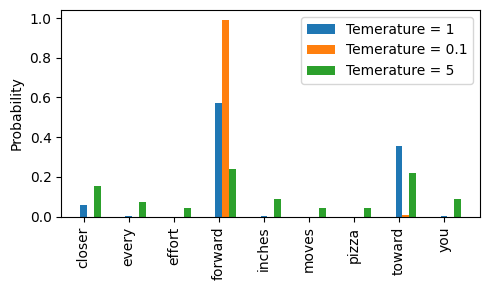

In [44]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

#   Temperatures greater than 1 result in more uniformly distributed token
# probabilities, and temperatures small than 1 will result in more confident
# (sharper or more peaky) distributions.
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T)
                 for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
                   bar_width, label=f"Temerature = {T}")

ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

### 5.3.2 Top-k sampling

- Top-k sampling, when combined with probabilistic sampling and temperature scaling can improvve the text generation resluts.  In top-k sampling, we can restric the sampled tokens to the top-k most likely tokens and exclude all other tokens from the selection process

In [45]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [46]:
#   Apply PyTorch where function to set the logit values of tokens that are
# below the lowest logit value within our top-three selection to negative
# infinity
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [47]:
#   Let's apply the softmax function to turn these into next-token probabilities:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3 Modifying the text generation function

In [48]:
#   Combine temperature sampling and top-k sampling to modify the
# generate_text_simple function
def generate(model, idx, max_new_tokens, context_size,
             temperature=0.0, top_k=None, eos_id=None):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:, -1, :]
    if top_k is not None:
      top_logits, _ = torch.topk(logits, top_k)
      min_val = top_logits[:, -1]
      logits = torch.where(
          logits < min_val,
          torch.tensor(float("-inf")).to(logits.device),
          logits
      )
    if temperature > 0.0:
      logits = logits / temperature
      probas = torch.softmax(logits, dim=1)
      idx_next = torch.multinomial(probas, num_samples=1)
    else:
      idx_next = torch.argmax(logits, dim=-1, keepdim=True)

    if idx_next == eos_id:
      break

    idx = torch.cat((idx, idx_next), dim=1)
  return idx

In [49]:
#   View the results of new generate function in action
torch.manual_seed(123)
token_ids = generate(
    model = model,
    idx = text_to_token_ids("Every effor moves you", tokenizer),
    max_new_tokens = 15,
    context_size = GPT_CONFIG_124M["context_length"],
    top_k = 25,
    temperature = 1.4
)

print("Output text: \n", token_ids_to_text(token_ids, tokenizer))

Output text: 
 Every effor moves you stand here; andforming, he saw his glory lifted the tips of a


## 5.4 - Loading and saving model weights in PyTorch

-